```
QUERYNAME = CholesterolMSMS;
DEFINE PR = 'C[41..49] H[30..200] O[2] N[1]' WITH DBR = (4.5,10.5), CHG = +1;
DEFINE FR ='C[27] H[45]' WITH DBR = (1,8), CHG = +1;

IDENTIFY

	PR IN MS1+ AND
	FR in MS2+

SUCHTHAT
	(avg(FR.intensity)/avg(PR.intensity) >=0.1 AND avg(FR.intensity)/avg(PR.intensity) <=10) AND
	PR.chemsc[C]/PR.chemsc[db] >= 4.6

REPORT 

	SPECIE = "CE %d:%d" % "((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)";  
	CLASS = "CE";
	MASS = PR.mass;
	ISOBARIC = PR.isobaric;
	CHEMSC = PR.chemsc;
	ERRppm = "%2.2f" % "(PR.errppm)";
	FRERRppm = "%2.2f" % "(FR.errppm)";
	INT = FR.intensity;
	QUALA = PR.intensity;
```

In [26]:
from targets import Targets_util
from MS_reader import SpectraUtil
from mfql_Parser import fromFile 

In [27]:
from chemParser import txt2dict

In [28]:
filename = '..\\test_resources\\small_test\\170213_CE_pos_MSMS.mfql'
mfql_dict = fromFile(filename)

In [29]:
mfql_dict

{'scriptname': 'CholesterolMSMS',
 'variables': [Var(id='PR', object=ElementSeq(txt='C[41..49] H[30..200] O[2] N[1]'), Options={'dbr': (4.5, 10.5), 'chg': 1}),
  Var(id='FR', object=ElementSeq(txt='C[27] H[45]'), Options={'dbr': (1, 8), 'chg': 1})],
 'identification': Evaluable(operation='AND', term_1=Evaluable(operation='IN', term_1='PR', term_2='MS1+'), term_2=Evaluable(operation='IN', term_1='FR', term_2='MS2+')),
 'suchthat': Evaluable(operation='AND', term_1=Evaluable(operation='AND', term_1=Evaluable(operation='>=', term_1=Evaluable(operation='/', term_1=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['FR', '.', 'intensity'])]), term_2=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'intensity'])])), term_2=0.1), term_2=Evaluable(operation='<=', term_1=Evaluable(operation='/', term_1=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['FR', '.', 'intensity'])]), term_2=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'i

In [30]:
mfql_dict['scriptname']

'CholesterolMSMS'

In [31]:
targets = [Targets_util.var2Target(var) for var in mfql_dict['variables']]


In [32]:
filename = '..\\test_resources\\small_test\\190321_Serum_Lipidextract_368723_01.mzML'
spectraUtil = SpectraUtil.fromFile(filename, test_sample=True)

In [33]:
MS1 = spectraUtil
MS2 = spectraUtil.get_reset_copy()
MS1.set_mode()
MS1.set_ms_level()
MS2.set_mode()
MS2.set_ms_level(2)


a copy of the original with nothing set... sorry no undo
set mode to positive : True, (false means negative) 
set ms level to  : 1
set mode to positive : True, (false means negative) 
set ms level to  : 2


In [34]:
PR = targets[0]
FR = targets[1]
MS1_match = MS1.get_nearest(PR._df)
MS2_match = MS2.get_nearest(FR._df)

find the nearest Peaks to the target_peaks with a tolerance of 0.01
find the nearest Peaks to the target_peaks with a tolerance of 0.01


## get only the nearest peak in each scan

In [35]:
MS1_match = Targets_util.set_max_daltons(MS1_match)
MS2_match = Targets_util.set_max_daltons(MS2_match)

In [36]:
MS1_match.columns

Index(['id', 'm', 'i', 'index', 'C', 'H', 'O', 'N', 'dbr', 'chem', 'target',
       'err', 'ppm'],
      dtype='object')

In [37]:
MS1_match.shape

(737, 13)

In [38]:
all_match = Targets_util.makeAllCombo(MS1_match, MS2_match)

In [39]:
all_match.columns

Index(['PR_id', 'PR_m', 'PR_i', 'PR_index', 'PR_C', 'PR_H', 'PR_O', 'PR_N',
       'PR_dbr', 'PR_chem', 'PR_target', 'PR_err', 'PR_ppm', 'FR_id', 'FR_m',
       'FR_i', 'FR_index', 'FR_C', 'FR_H', 'FR_dbr', 'FR_chem', 'FR_target',
       'FR_err', 'FR_ppm'],
      dtype='object')

In [40]:
# for iloc1 try fr.chemsc + 'C14 H27 O2 N1' = pr.chemsc
all_match.iloc[0]

PR_id        controllerType=0 controllerNumber=1 scan=6
PR_m                                            610.555
PR_i                                            468.968
PR_index                                             42
PR_C                                                 41
PR_H                                                 72
PR_O                                                  2
PR_N                                                  1
PR_dbr                                              6.5
PR_chem                                   C41 H72 O2 N1
PR_target                                       610.556
PR_err                                       0.00146484
PR_ppm                                           2.3992
FR_id        controllerType=0 controllerNumber=1 scan=7
FR_m                                            369.351
FR_i                                            1701.85
FR_index                                              0
FR_C                                            

In [41]:
mfql_dict['suchthat']

Evaluable(operation='AND', term_1=Evaluable(operation='AND', term_1=Evaluable(operation='>=', term_1=Evaluable(operation='/', term_1=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['FR', '.', 'intensity'])]), term_2=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'intensity'])])), term_2=0.1), term_2=Evaluable(operation='<=', term_1=Evaluable(operation='/', term_1=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['FR', '.', 'intensity'])]), term_2=Func(func='avg', on=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'intensity'])])), term_2=10)), term_2=Evaluable(operation='>=', term_1=Evaluable(operation='/', term_1=Obj(p_rule='p_withAttr_accessItem_', p_values=['PR', '.', 'chemsc', '[', 'C', ']']), term_2=Obj(p_rule='p_withAttr_accessItem_', p_values=['PR', '.', 'chemsc', '[', 'db', ']'])), term_2=4.6))

In [42]:
from suchthat2txt import suchthat2txt

In [43]:
st = suchthat2txt(mfql_dict['suchthat'])
st

'FR_i / PR_i >= 0.1 and FR_i / PR_i <= 10 and PR_C / PR_dbr >= 4.6'

In [44]:
# # (avg(FR.intensity)/avg(PR.intensity) >=0.1 AND avg(FR.intensity)/avg(PR.intensity) <=10) AND
# 	PR.chemsc[C]/PR.chemsc[db] >= 4.6

ST = all_match.query(st)
ST.shape

(4767, 24)

# make it a summary like the current lx, 
# one entry one line


In [45]:
pr_df, fr_df = Targets_util.devideAllCombo(ST)

In [46]:
pr_df[pr_df.PR_chem== 'C41 H76 O2 N1 P1']

,PR_id,PR_m,PR_i,PR_index,PR_C,PR_H,PR_O,PR_N,PR_dbr,PR_chem,PR_target,PR_err,PR_ppm


In [47]:
sum_df = Targets_util.summaryDF(pr_df, quantile=1)
sum_df

,PR_C_dbr,PR_ppm_mean,PR_i_mean,PR_i_rsd,PR_count
35,"(46.0, 7.5)",0.000000,1.411390e+05,NaN,1
25,"(45.0, 5.5)",0.665607,1.255564e+07,29.564574,24
33,"(46.0, 6.5)",0.728600,6.180155e+05,43.812999,24
0,"(41.0, 4.5)",0.736990,2.070845e+05,48.203930,19
9,"(43.0, 6.5)",0.764627,1.762567e+04,NaN,1
15,"(44.0, 5.5)",0.818420,1.455230e+05,21.400088,9
48,"(47.0, 9.5)",0.856816,4.251717e+05,67.124987,24
5,"(43.0, 4.5)",0.862724,6.460362e+06,31.320658,24
27,"(45.0, 6.5)",0.889956,5.790239e+07,35.738257,25
23,"(45.0, 4.5)",0.979256,4.520256e+05,57.228941,25


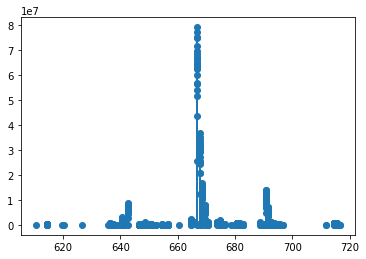

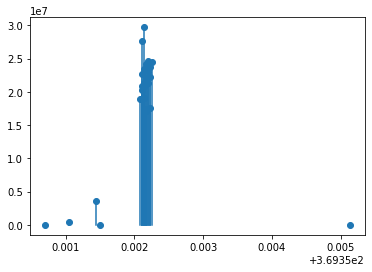

In [48]:
plt = Targets_util.lollipop_plot(pr_df.PR_m, pr_df.PR_i)
plt.show()
plt = Targets_util.lollipop_plot(fr_df.FR_m, fr_df.FR_i)
plt.show()

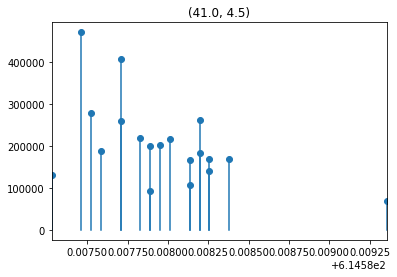

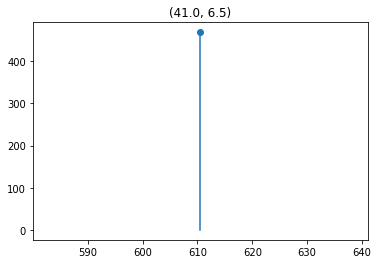

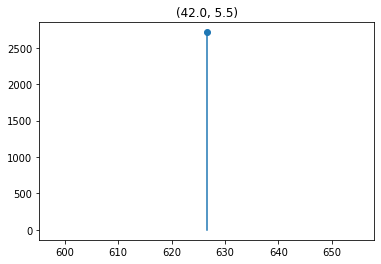

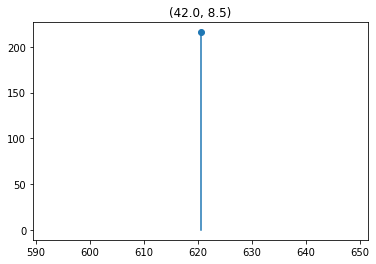

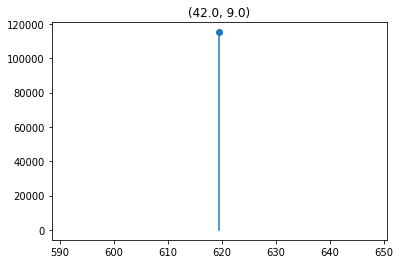

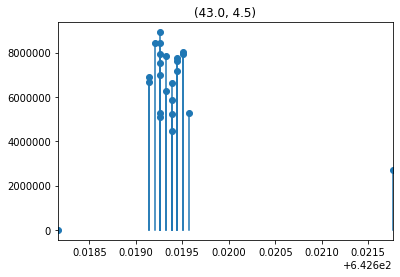

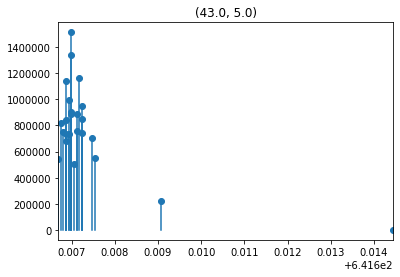

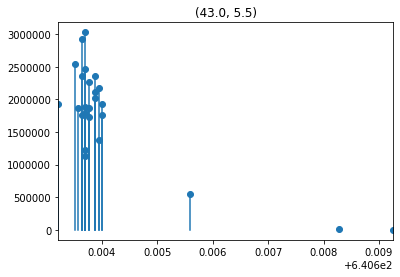

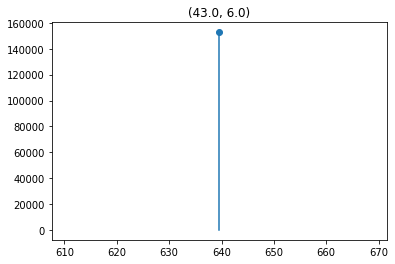

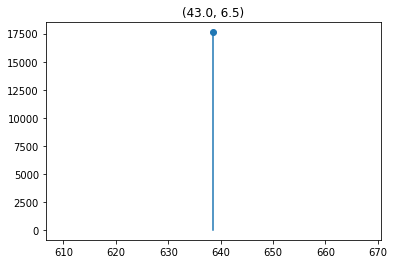

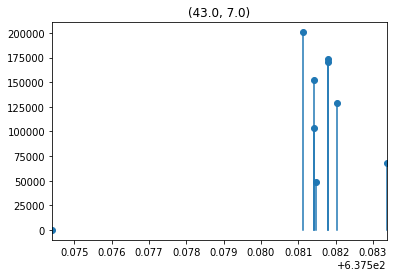

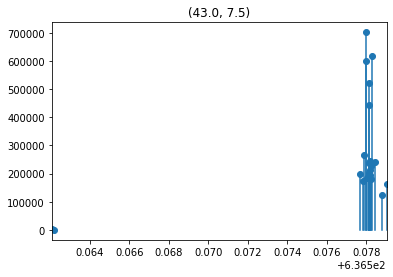

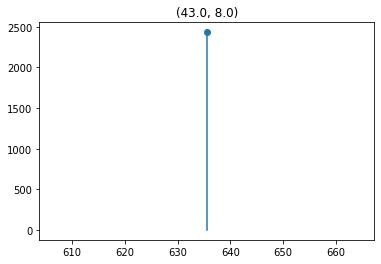

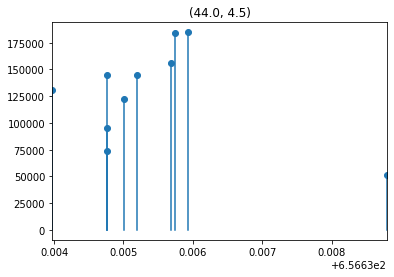

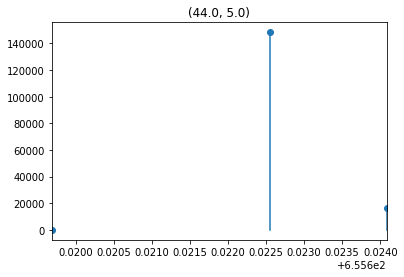

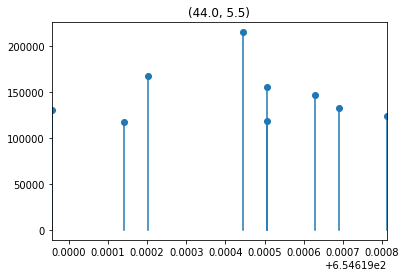

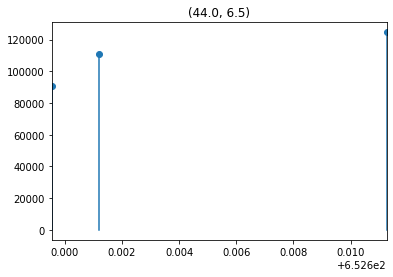

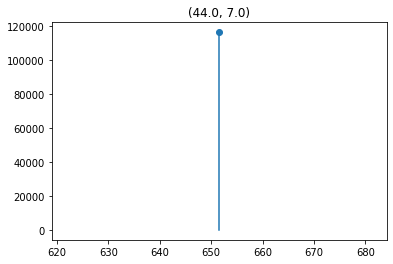

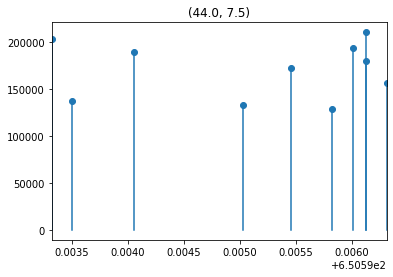

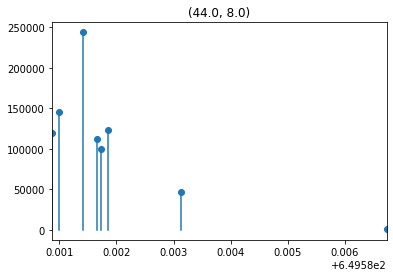

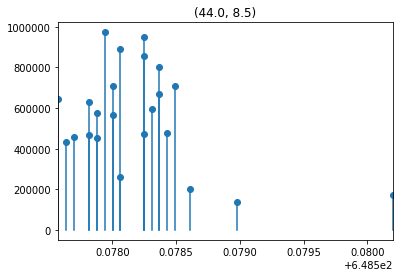

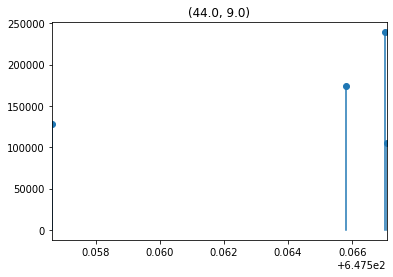

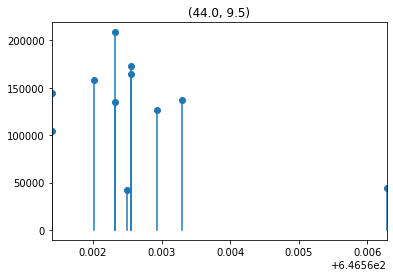

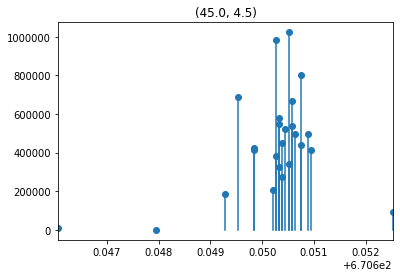

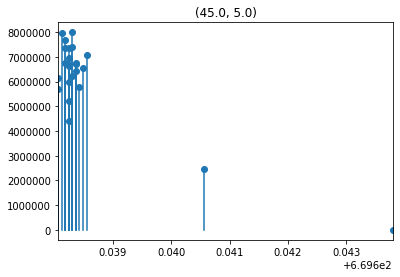

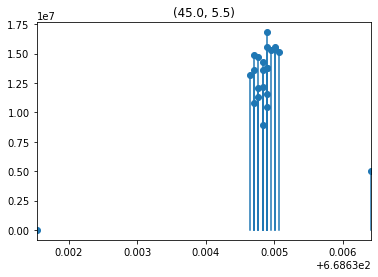

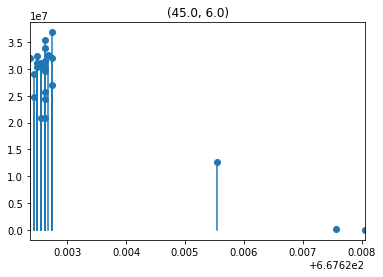

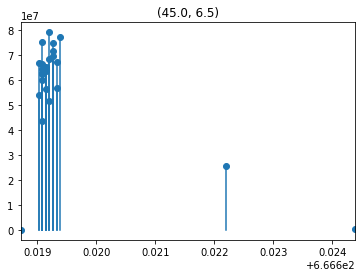

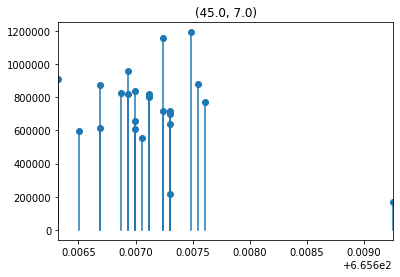

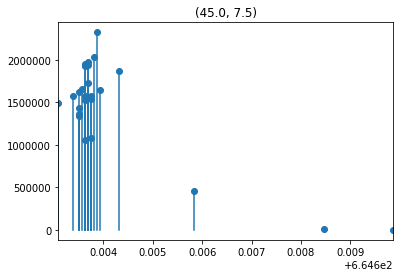

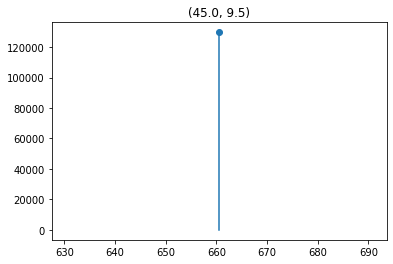

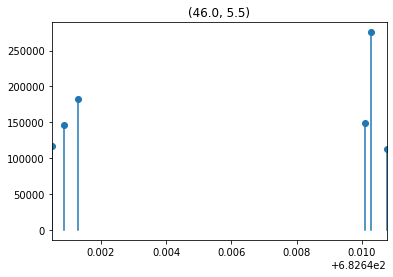

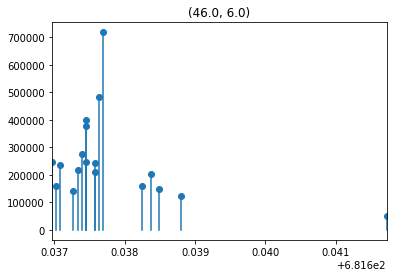

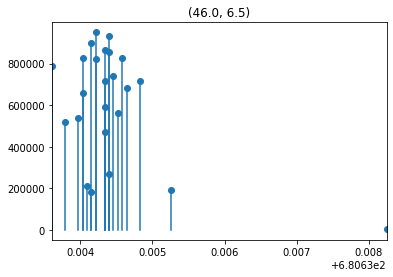

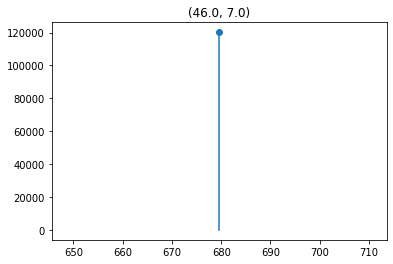

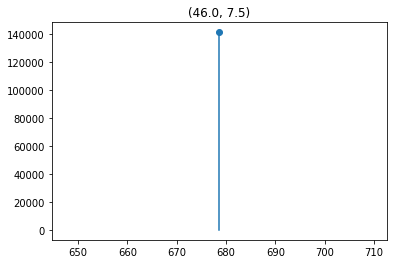

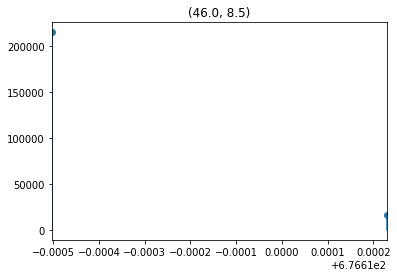

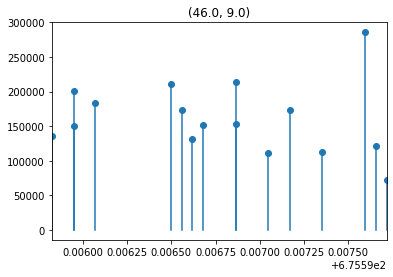

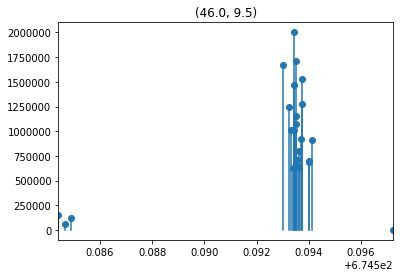

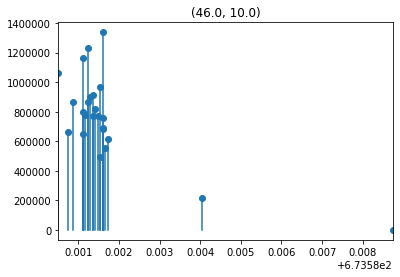

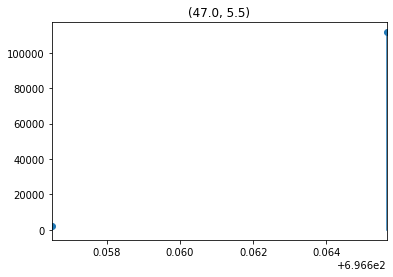

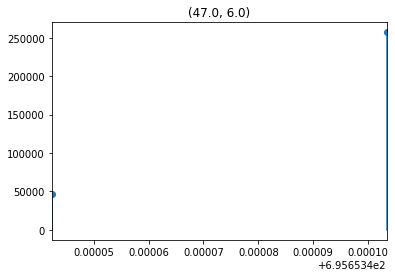

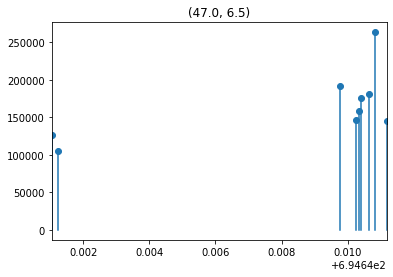

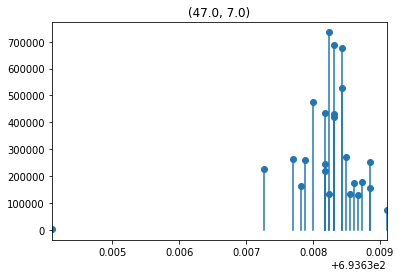

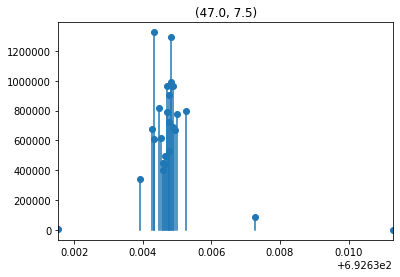

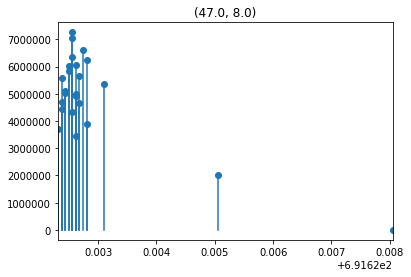

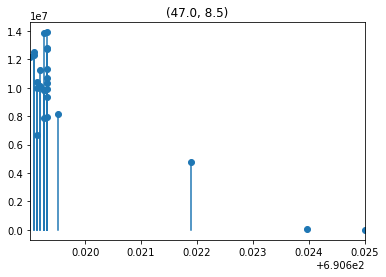

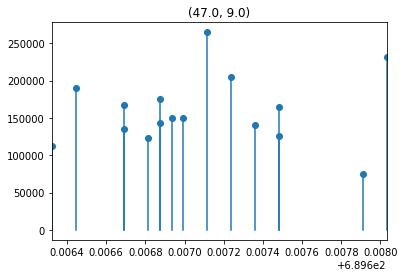

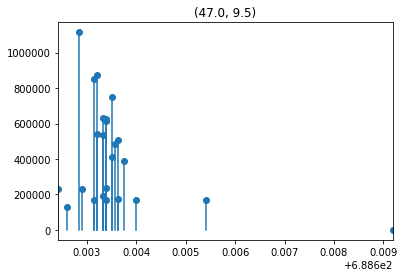

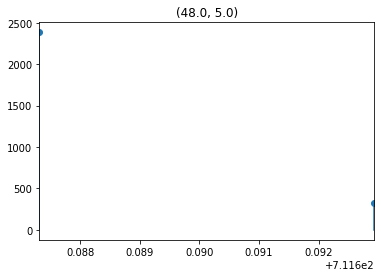

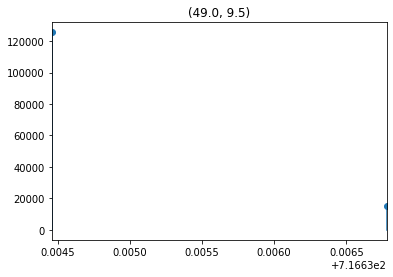

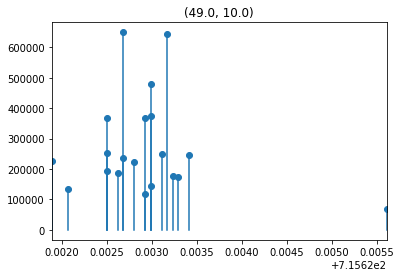

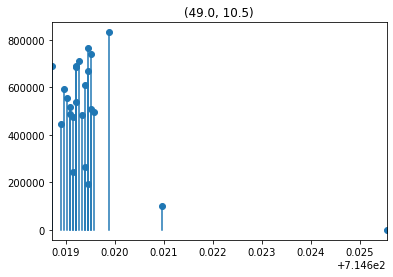

In [49]:
Targets_util.showAll_lollipop(pr_df, sample = False)

# in the XML annotate with 'selectedIonList'

In [51]:
report = mfql_dict['report']

In [56]:
from suchthat2txt import txt
[txt(r.p_values) for r in report]

c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\suchthat2txt.py:48: UserWarning: did not evaluate ['"CE %d:%d"', '%', '"((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)"']
  if res == None: warnings.warn(f'did not evaluate {evaluable}')
c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\suchthat2txt.py:45: UserWarning: could not evaluate CE
  warnings.warn(f'could not evaluate {evaluable}')
c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\suchthat2txt.py:48: UserWarning: did not evaluate Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'mass'])
  if res == None: warnings.warn(f'did not evaluate {evaluable}')
c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\suchthat2txt.py:48: UserWarning: did not evaluate [Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'mass'])]
  if res == None: warnings.warn(f'did not evaluate {evaluable}')
c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\suchthat2txt.py:48: UserWarning: did not evaluate Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'i

[None,
 'CE',
 None,
 '2',
 '2',
 None,
 'PR_target',
 None,
 None,
 'FR_i',
 'PR_i',
 'PR_i',
 'PR_i']

In [58]:
report

[ReportItem(id='SPECIE', p_values=['"CE %d:%d"', '%', '"((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)"']),
 ReportItem(id='CLASS', p_values=['CE']),
 ReportItem(id='MASS', p_values=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'mass'])]),
 ReportItem(id='IDMSLEVEL', p_values=[2]),
 ReportItem(id='QUANTMSLEVEL', p_values=[2]),
 ReportItem(id='ISOBARIC', p_values=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'isobaric'])]),
 ReportItem(id='CHEMSC', p_values=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'chemsc'])]),
 ReportItem(id='ERRppm', p_values=['"%2.2f"', '%', '"(PR.errppm)"']),
 ReportItem(id='FRERRppm', p_values=['"%2.2f"', '%', '"(FR.errppm)"']),
 ReportItem(id='INT', p_values=[Obj(p_rule='p_withAttr_id', p_values=['FR', '.', 'intensity'])]),
 ReportItem(id='QUALA', p_values=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'intensity'])]),
 ReportItem(id='QUALB', p_values=[Obj(p_rule='p_withAttr_id', p_values=['PR', '.', 'intensity'])]),
 ReportItem(id='QUALC', p_val

In [62]:
reportItem = report[0]
reportItem

ReportItem(id='SPECIE', p_values=['"CE %d:%d"', '%', '"((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)"'])

In [66]:
def reportItem2Col(reportItem, df):
    col = reportItem.id
    if reportItem.p_values[1] == '%':# its a formatter
        p_format = reportItem.p_values[0]
        p_expressions = reportItem.p_values[2]
        p_expressions = p_expressions.strip(['"','(',')'])
    else
        res = txt(reportItem.p_values) 
    return res

In [70]:
reportItem2Col(reportItem, ST)

'SPECIE'

In [80]:
  "CE %d:%d" % (ST.iloc[0].PR_C - 27, ST.iloc[0].PR_dbr - 4.5)

'CE 19:2'

In [83]:
txt(reportItem.p_values[2][1:-1])

c:\Users\mirandaa\Desktop\lx128_p3\lipidxplorer\lx2\suchthat2txt.py:45: UserWarning: could not evaluate ((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)
  warnings.warn(f'could not evaluate {evaluable}')


'((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)'

In [85]:
reportItem.p_values

['"CE %d:%d"', '%', '"((PR.chemsc)[C] - 27, (PR.chemsc)[db] - 4.5)"']

In [1]:
l = ['1','2']
l

['1', '2']

In [3]:
l[1:2]


['2']